# HadGEM3-GC31_25km Seasonal Data from Monthly Data and Plotting

In [1]:
import xarray as xr
import rioxarray
import numpy as np
import netCDF4
import os
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mpl_colors
import math
import geopandas as gpd
import calendar

ds = xr.open_dataset(r"E:\Script\MSP_Data_office_PC\CMIP6\Data\HadGEM3-GC31-MM_ssp585_r1i1p1f3_gn_25km.nc")
ouput_folder_path = r"E:\Script\MSP_Data_office_PC\CMIP6\Output"

latitude_boundary = [16, 24]
longitude_boundary = [81, 95]

llc_lat_idx = np.argmin(np.abs(ds['latitude'][:,1].data - latitude_boundary[0]))
lrc_lat_idx = np.argmin(np.abs(ds['latitude'][:,1].data - latitude_boundary[1]))

llc_lon_idx = np.argmin(np.abs(ds['longitude'][1,:].data - longitude_boundary[0]))
lrc_lon_idx = np.argmin(np.abs(ds['longitude'][1,:].data - longitude_boundary[1]))


winter_months = [time.data.tolist() for time in ds.time if time.dt.month.data in [1, 2, 12] and time.dt.year.data == 2070]
summer_months = [time.data.tolist() for time in ds.time if time.dt.month.data in [6, 7, 8] and time.dt.year.data == 2070]

season_dict = {'Winter': winter_months, 'Summer': summer_months}

season_ds_list = []

for season in season_dict.keys():
    
    season_ds = ds.sel(time = season_dict[season],
                       i = slice(ds['i'][llc_lon_idx].data, ds['i'][lrc_lon_idx].data),
                       j = slice(ds['j'][llc_lat_idx].data, ds['j'][lrc_lat_idx].data))
    
    season_mean_ds = season_ds.mean(dim= ['time'], skipna=True, keep_attrs=True)

    season_array = np.array([season], dtype = str)
    
    for var in season_mean_ds.data_vars:
        season_mean_ds[var] = season_mean_ds[var].expand_dims(season=season_array, axis=0)
        
    ds_name = '{}_ds'.format(season)
    ds_name = season_mean_ds
    season_ds_list.append(ds_name)

combined_sesason_ds = xr.concat(season_ds_list , dim = 'season')
season_name_array = combined_sesason_ds['season'].to_numpy()

combined_sesason_ds.to_netcdf(os.path.join(ouput_folder_path, 'HadGEM-3_25km_Seasonal_Sea_Surface_Temperature_2070.nc'))

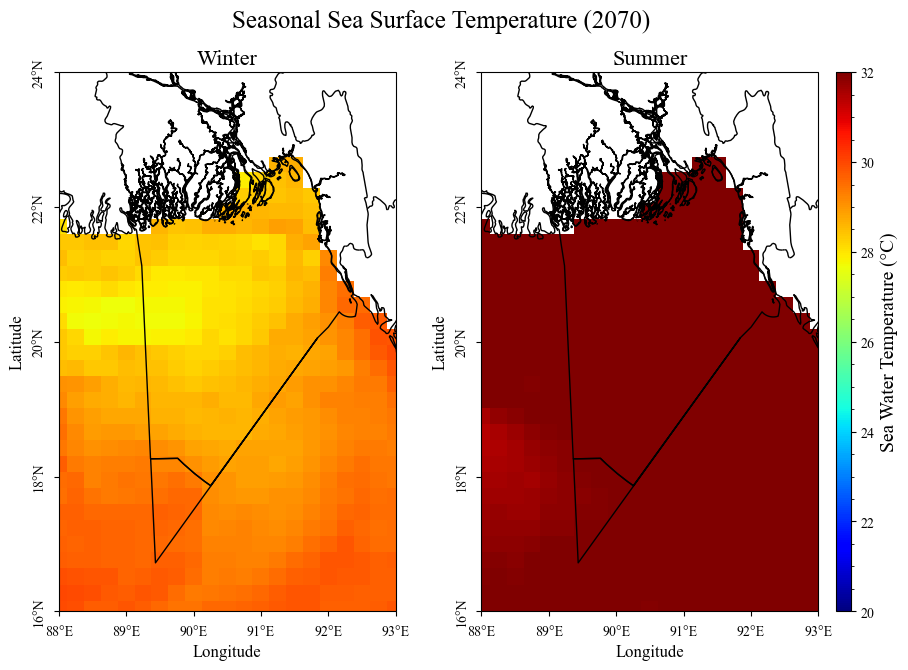

In [2]:
import xarray as xr
import rioxarray
import numpy as np
import netCDF4
import os
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mpl_colors
import math
import geopandas as gpd
import calendar

ds = xr.open_dataset(r"E:\Script\MSP_Data_office_PC\CMIP6\Output\HadGEM-3_25km_Seasonal_Sea_Surface_Temperature_2070.nc")
gdf = gpd.read_file(r"E:\Script\MSP_Data_office_PC\Shape_File\Exclusive_Economic_Zone_and_Maritime_Boundary.shp")

# Determining overall color range based on the data
overall_vmin = 27      # math.ceil(np.min(data.variables['to'][:,0,:,:]))
overall_vmax = 35      # math.floor(np.min(data.variables['to'][:,0,:,:]))

# Creating a common colormap
cmap = plt.get_cmap('jet')

latitude = combined_sesason_ds['latitude'][:,0].data
longitude = combined_sesason_ds['longitude'][0,:].data
season = combined_sesason_ds['season'].data
sea_water_temp = combined_sesason_ds['tos'][:]

lon, lat = np.meshgrid(longitude, latitude)


    
font = {'family' : 'Times New Roman',              
        'weight' : 'normal',  
        'size'   : 10}

plt.rc('font',**font)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

fig, ax = plt.subplots(ncols = 2, figsize=(10,7), subplot_kw={'projection': ccrs.PlateCarree()})

for i in range(0, len(season)):
    
    extent = (88, 93, 16, 23.875)
    ax[i].set_extent(extent, ccrs.PlateCarree())

    mp = ax[i].pcolormesh(lon, lat, np.squeeze(sea_water_temp[i, :, :]), cmap=cmap, 
                             norm=mpl_colors.Normalize(vmin=overall_vmin, vmax=overall_vmax))

    ax[i].add_feature(cfeature.COASTLINE)
    ax[i].add_feature(cfeature.BORDERS)

    color_dict = {'facecolor': 'none', 'edgecolor': 'black'}

    for row in gdf.iterrows():
        geom = gpd.GeoSeries(row[1].geometry)
        ax[i].add_geometries(geom, ccrs.PlateCarree(), **color_dict)
        
    xticks = np.arange(88, 94, 1)
    ax[i].set_xticks(xticks)
    ax[i].tick_params(axis='x', pad =6)
    ax[i].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x}\u00b0E"))

    yticks = np.arange(16, 25, 2)
    ax[i].set_yticks(yticks)
    ax[i].tick_params(axis='y', labelrotation=90, pad =6)
    ax[i].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x}\u00b0N"))

    ax[i].set_xlabel('Longitude', fontsize=12)
    ax[i].set_ylabel('Latitude', fontsize=12)

    plt.setp(ax[i].get_yticklabels(), va='center')
    plt.setp(ax[i].get_xticklabels(), ha='center')
    
    ax[i].set_title('{}'.format(season[i]), fontsize=16)

# [left, bottom, width, height] 
cbar_ax = fig.add_axes([0.91, 0.11, 0.015, 0.77]) 
fig.colorbar(mp, cax=cbar_ax, cmap=cmap, orientation='vertical', pad=0.02, shrink=5.5,
                 norm=mpl_colors.Normalize(vmin=overall_vmin, vmax=overall_vmax))
# cbar_ax.invert_yaxis()
cbar_ax.minorticks_on()
cbar_ax.set_ylabel('Sea Water Temperature (\u00b0C)', fontsize = 14)

fig.suptitle('Seasonal Sea Surface Temperature (2070)', fontsize=18, x=0.515, y = 0.97)
plt.savefig(r'G:\MJI\SKZ\Script\MSP_Data\Output\Seasonal\CMIP6\HadGEM-3_25km\HadGEM-3_Seasonal_Sea_Water_Temperature_2070.jpg',
            dpi=300, bbox_inches = 'tight')

plt.show()